## 原始数据加载

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import Binarizer
import pickle
import os

oriDataPath = "./oriData/"
cache = "./cache/"
modelRapo = "./modelRapo/"

with open(oriDataPath+"train.pkl", "rb") as f:
    train_df = pickle.load(f)

questions = pd.read_csv(oriDataPath + "questions.csv", dtype={"question_id":'int16',"correct_answer":"int8"})
lectures = pd.read_csv(oriDataPath + "lectures.csv", dtype={"lecture_id":"int16"})

## 基本分析

### 用户数量

In [2]:
train_df[["user_id"]].drop_duplicates(subset=["user_id"])

,user_id
0,115
46,124
76,2746
96,5382
224,8623
...,...
101228989,2147470770
101229217,2147470777
101229975,2147481750
101230025,2147482216


用户数量：393656

### 题目数量&是否有题目需要冷启动

In [6]:
train_df.loc[train_df["content_type_id"]==0, ["content_id"]].drop_duplicates().sort_values(by=["content_id"])

,content_id
7617,0
6916,1
894,2
4192,3
20,4
...,...
21480,13518
1765,13519
108490,13520
43583,13521


In [7]:
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
...,...,...,...,...,...
13518,13518,13518,3,5,14
13519,13519,13519,3,5,8
13520,13520,13520,2,5,73
13521,13521,13521,0,5,125


题目总数量：13523 所有问题都有用户回答记录，不需要冷启动

### 课程数量

In [8]:
train_df.loc[train_df["content_type_id"]==1, ["content_id"]].drop_duplicates().sort_values(by=["content_id"])

,content_id
2210,89
2585,100
224620,185
6234,192
2130,317
...,...
12278,32535
26804,32570
21243219,32604
32018,32625


In [9]:
lectures

,lecture_id,tag,part,type_of
0,89,24584,5,concept
1,100,22243,1,concept
2,185,7035,6,concept
3,192,31458,5,solving question
4,317,19653,5,solving question
...,...,...,...,...
413,32535,20004,5,solving question
414,32570,4358,3,solving question
415,32604,9093,6,concept
416,32625,23993,2,concept


课程总数量：418 有3个课程没有听课记录

### 用户答题数量分布

In [4]:
# 用户答题数量分布
tmp = train_df.loc[train_df.content_type_id == 0,:].groupby(["user_id"]).agg({"answered_correctly":["count","sum"]})
tmp.columns = ["answer_sum","correct_answer_sum"]
tmp["correct_rate"] = tmp["correct_answer_sum"]/tmp["answer_sum"]
bn = Binarizer(threshold=0.6)
tmp["is_half_correct_rate"] = bn.transform([tmp["correct_rate"]])[0]

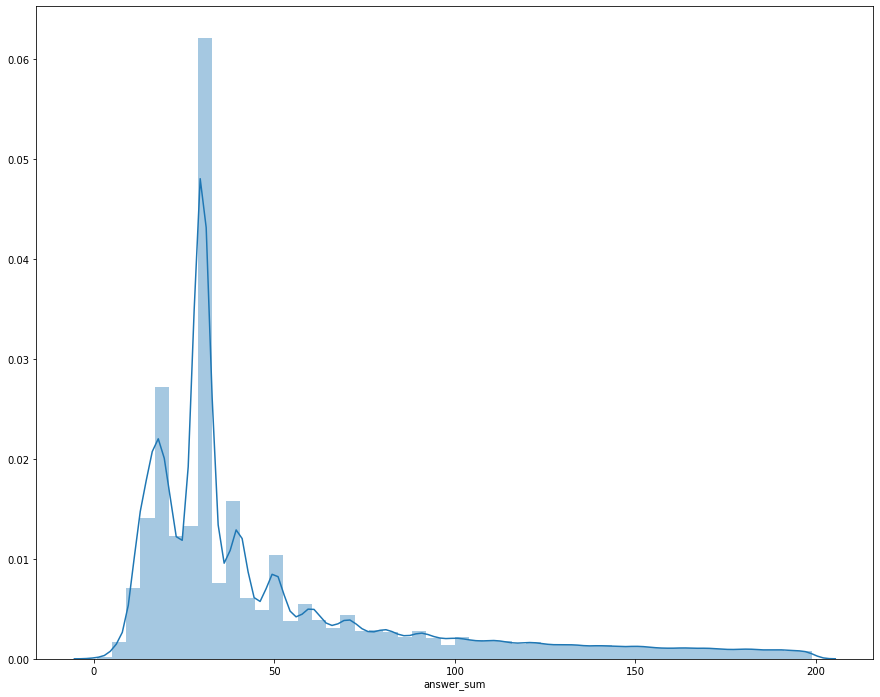

In [39]:
# 答题数量分布(<1000)
plt.figure(figsize=(15,12))
sns.distplot(tmp.loc[tmp.answer_sum<200,"answer_sum"])

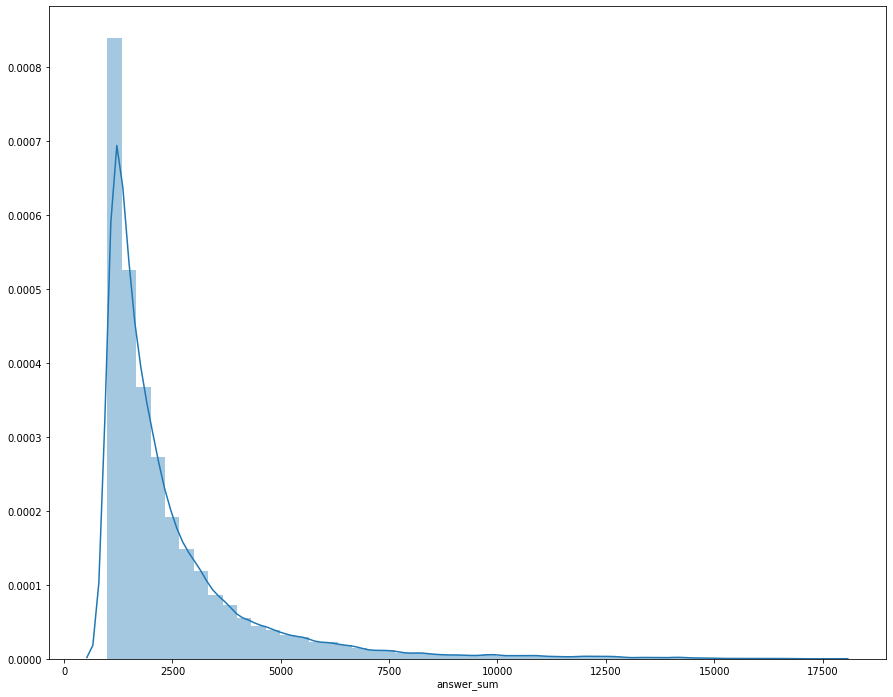

In [59]:
# 答题数量分布(>1000)
plt.figure(figsize=(15,12))
sns.distplot(tmp.loc[tmp.answer_sum>=1000,"answer_sum"])

学生答题数量符合长尾分布，大部分同学答题数量在0-100之间

### 用户答题准确率分布

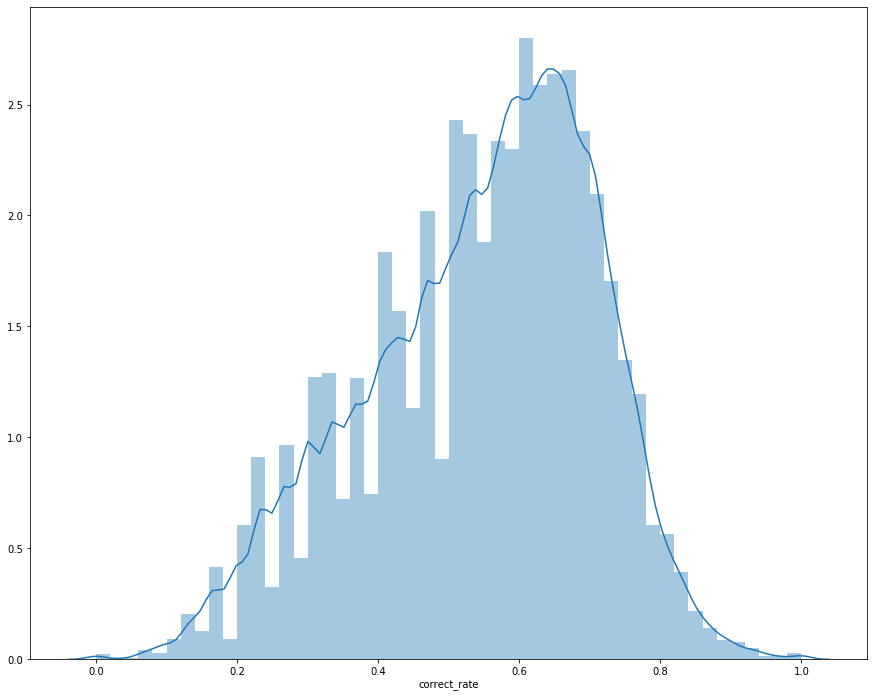

In [60]:
# 答题正确率分布
plt.figure(figsize=(15,12))
sns.distplot(tmp["correct_rate"])

- 学生答题准确率集中在60%-70%
- 高分的同学人数较为集中，分布较为稳定，基本呈现准确率越高，人数越少
- 低分区域的同学则呈现一定的不规律波动

### 听课情况 

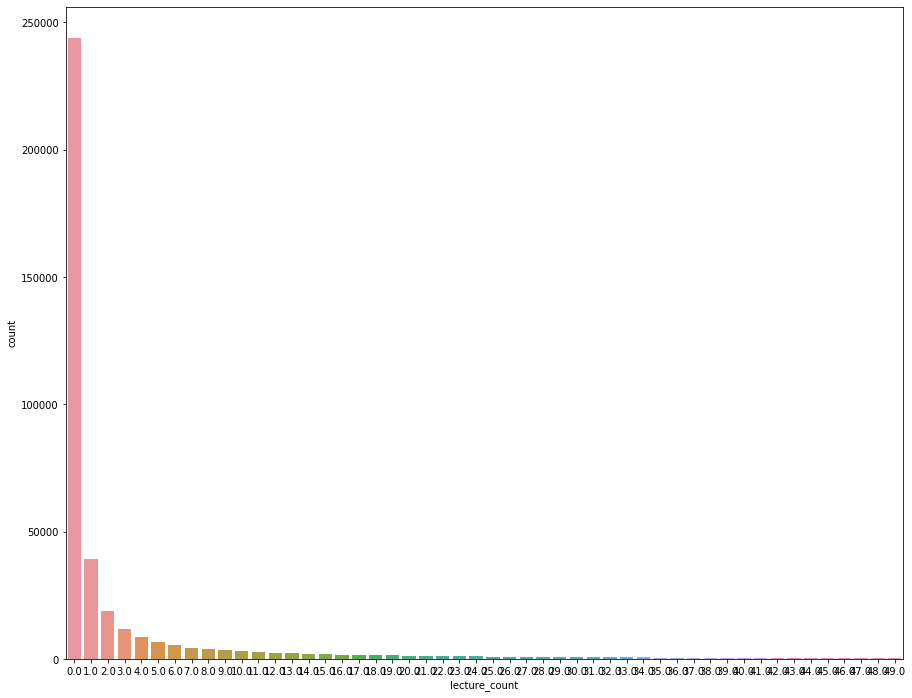

In [5]:
# 听课情况
tmp2 = train_df.loc[train_df.content_type_id==1,:].groupby(["user_id"]).\
agg({"answered_correctly":"count"})
tmp2.columns = ["lecture_count"]

tmp3 = pd.concat([tmp,tmp2], axis=1)
tmp3["lecture_count"].fillna(0, inplace=True)

plt.figure(figsize=(15,12))
sns.countplot(tmp3.loc[tmp3.lecture_count<50,"lecture_count"])

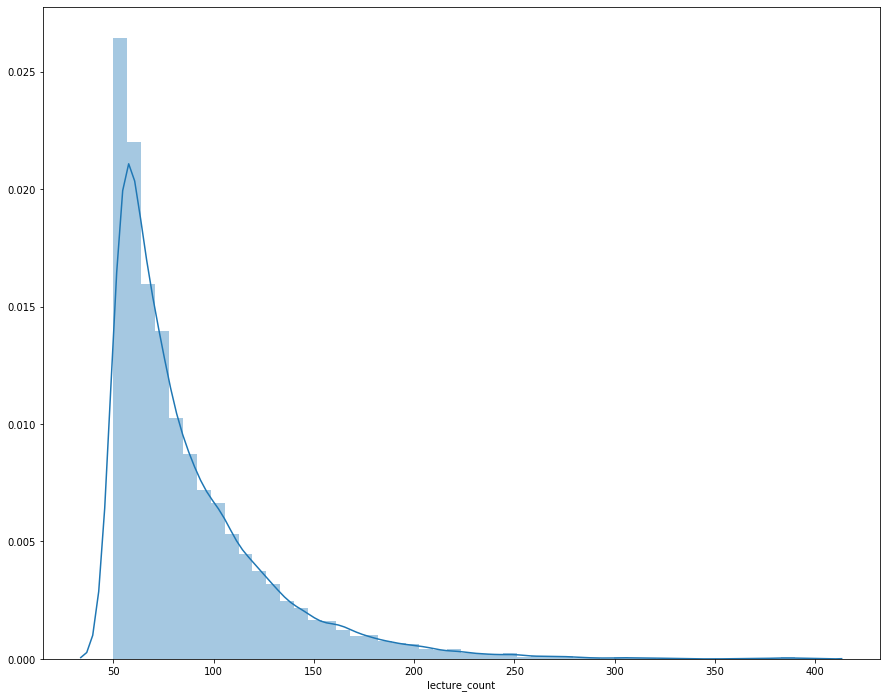

In [27]:
plt.figure(figsize=(15,12))
sns.distplot(tmp3.loc[tmp3.lecture_count>=50,"lecture_count"])

- 坚持听课的同学随着听课次数的增多递减
- 多数同学不听课或少听课
- 将近250000的同学没有听过课，听过一次的课的同学不足50000人，听过两次课的同学不足25000人

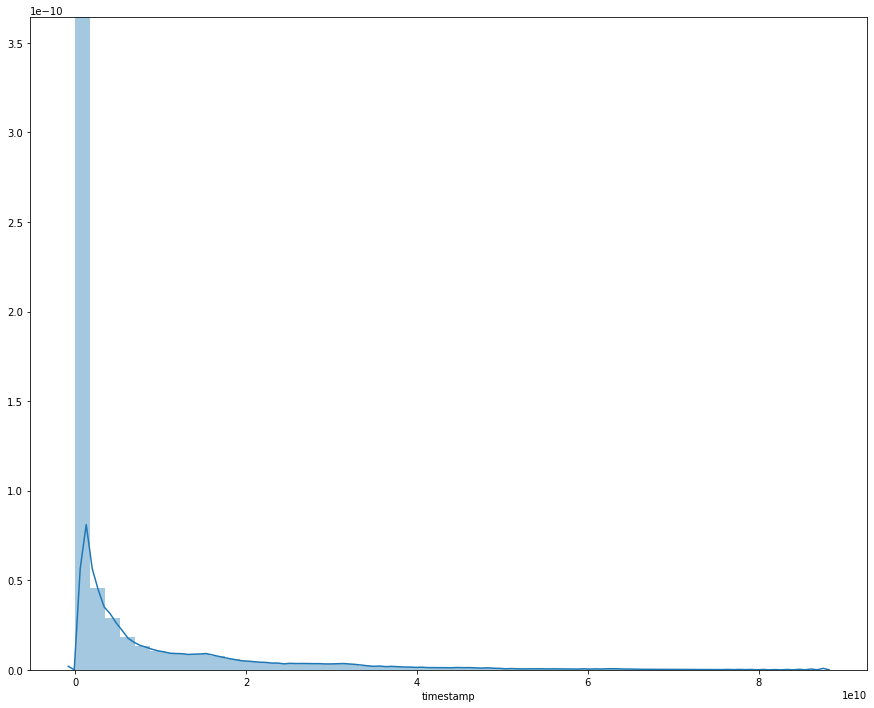

In [6]:
# 学生学习时间
active_duration = train_df.groupby(["user_id"]).agg({"timestamp":np.ptp})
plt.figure(figsize=(15,12))
sns.distplot(active_duration["timestamp"])

## 关联分析

### 做题数量与正确回答数量

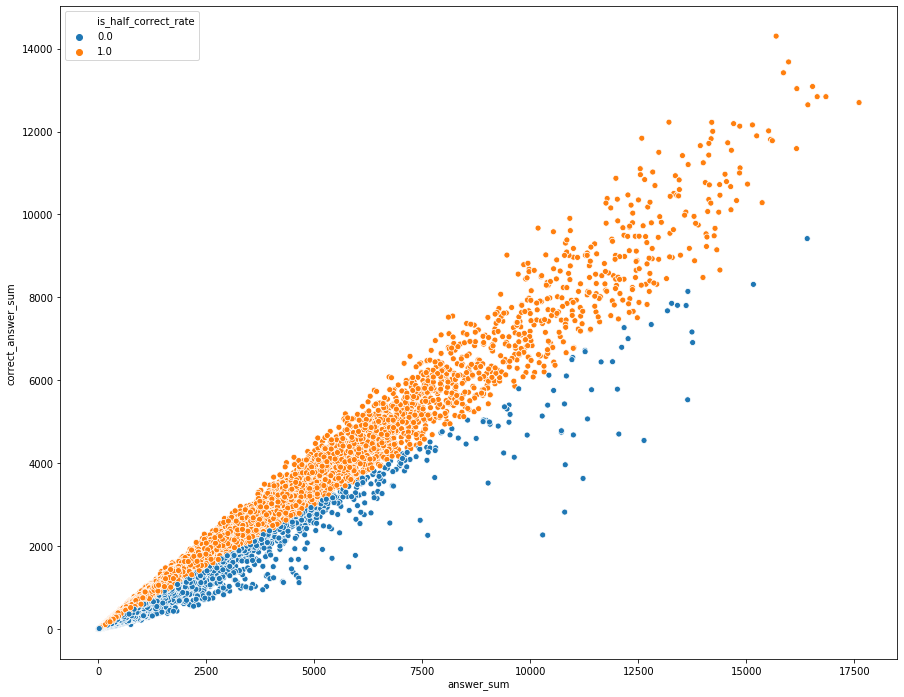

In [56]:
# 答题数量与回答正确数量
plt.figure(figsize=(15,12))
sns.scatterplot( x="answer_sum",y="correct_answer_sum",data=tmp, hue="is_half_correct_rate")

- 成绩在及格线以上的同学较多
- 做题更多的同学及格率更高

### 验证上述做题数量和准确率的关系

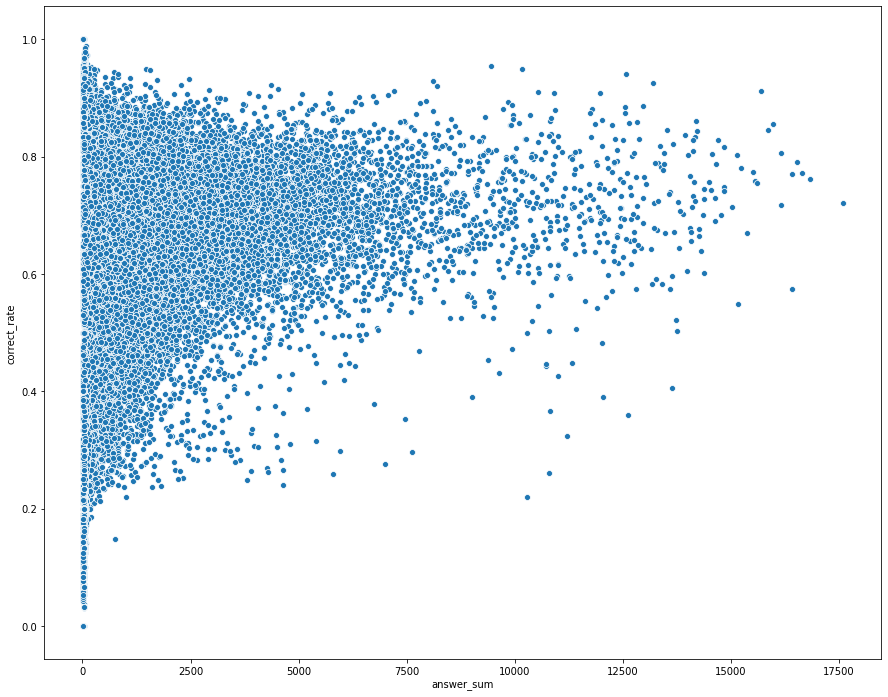

In [65]:
# 验证上述做题数量和准确率的关系
plt.figure(figsize=(15,12))
sns.scatterplot( x="answer_sum",y="correct_rate",data=tmp)

- 随着做题数量的增加,准确率有提升
- 随着做题数量的增加,准确率的分布趋于稳定

### 重复作答的情况

In [8]:
# 是否有重复回答同一题目的现象
repeat_question = train_df.loc[train_df.content_type_id==0,:].groupby(["user_id","content_id"]).agg({"answered_correctly":"count"})

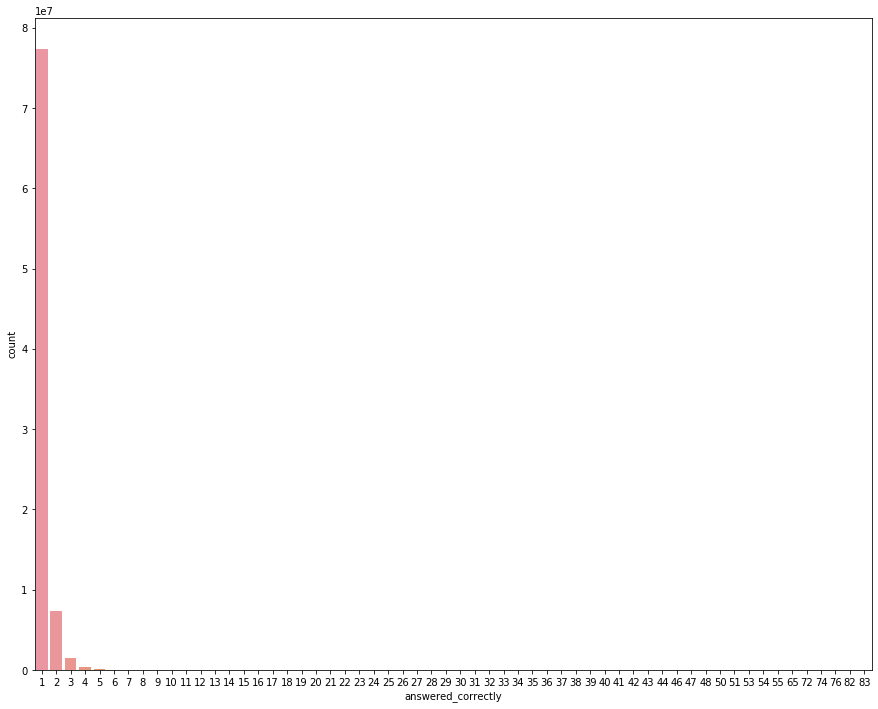

In [11]:
plt.figure(figsize=(15,12))
sns.countplot(repeat_question.answered_correctly)

- 存在对相同题目的重复作答记录

### 坚持多听课对答题的影响

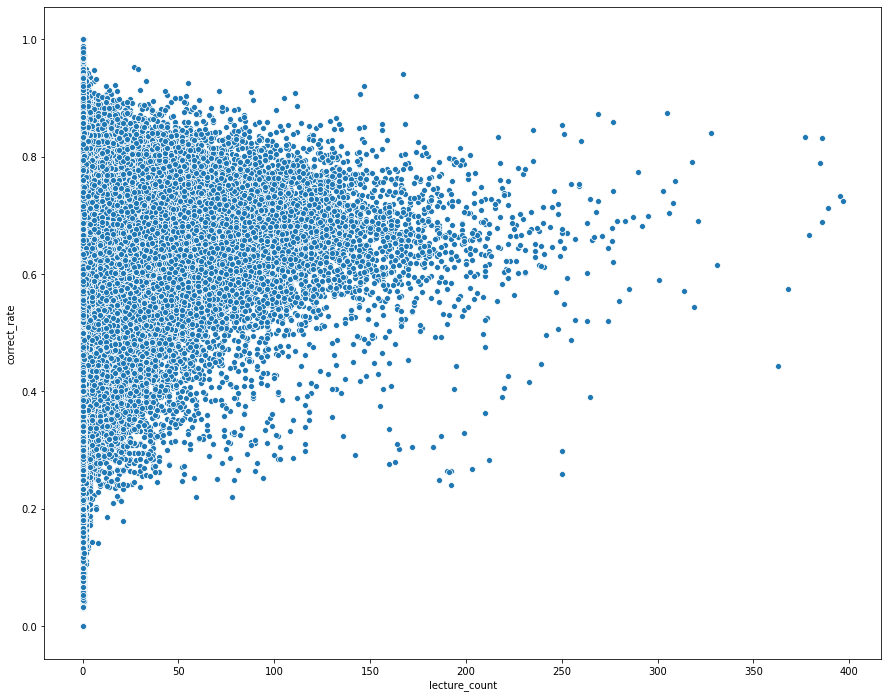

In [28]:
# 坚持听课是否对回答问题有正面影响
plt.figure(figsize=(15,12))
sns.scatterplot(x="lecture_count", y="correct_rate", data=tmp3)

- 多听课的学生准确率更高
- 多听课的学生准确率更加稳定
- 可能因为多做题的同学也多听课，两者可能具备较强的相关性

### 多做题的同学是否也多听课

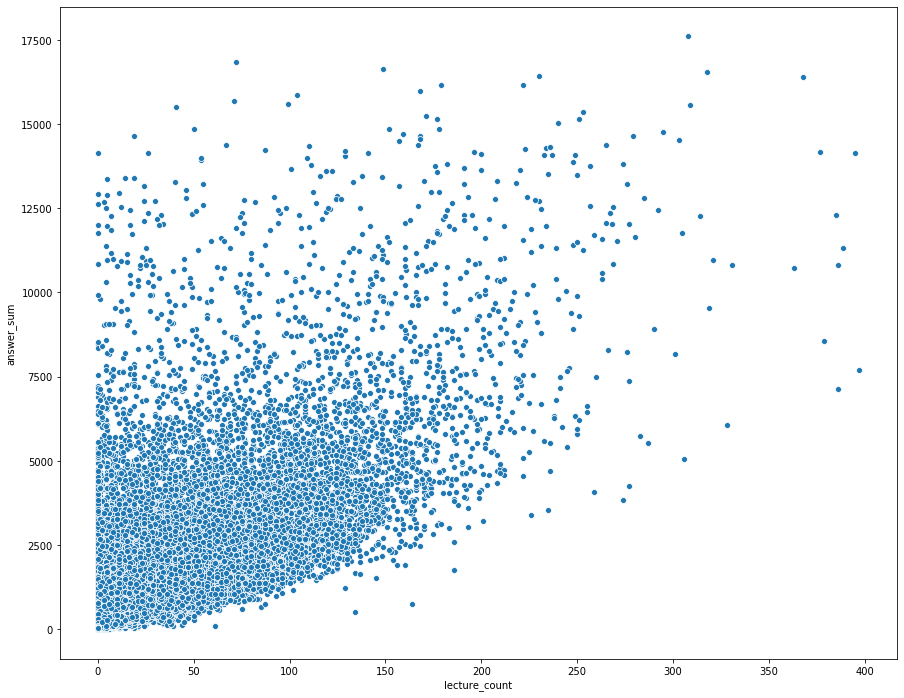

In [29]:
# 验证上述猜想：多做题的同学是否也多听课
plt.figure(figsize=(15,12))
sns.scatterplot(x="lecture_count", y="answer_sum", data=tmp3)

- 有一定相关性
- 存在大量不相关信息

## baseline
- 本项目旨在预测学生能否在指定题目上做出正确的解答
- 项目提供以下数据
    - 学生的历史行为记录，包括做题记录，听课记录
    - 课程基础数据
    - 题目基础数据
- 项目未提供学生基础特征数据，需要从用户历史行为构造行为特征，用户预测未来行为
- 用户行为是时间序列，一般而言学生答题能力会成长，需要避免使用未来行为预测过去行为的情况

### 载入样本&特征
- get_sample方法默认采样每个用户最后10次答题记录作为样本
- get_usr_acc_feat方法默认返回与默认样本匹配的用户累积行为特征，包括用户答题准确率，答题数量等

In [7]:
from core.base import get_sample
from core.feature import get_usr_acc_feat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [8]:
sample = get_sample()[0]

get len of sample_0_10:3928411
get len of behave_for_sample_0_10:97301921


In [9]:
usr_acc_feat = get_usr_acc_feat()

succeed get usr_acc_feat_for_sample_0_10


### 合并特征&baseline预测
- baseline预测采用用户答题准确率作为预测结果，陌生用户以0.5作为预测值

In [10]:
sample = pd.merge(sample, usr_acc_feat, on=["user_id"], how="left")
sample["usr_accuracy"].fillna(0.5, inplace=True)

sample_y = sample["answered_correctly"]
sample_X = sample.drop(columns=["answered_correctly"])

train_X, valid_X, train_y, valid_y = train_test_split(sample_X, sample_y, test_size=0.2, shuffle=True)

In [12]:
print("训练集auc:{}".format(roc_auc_score(train_y, train_X.usr_accuracy)))
print("训练集auc:{}".format(roc_auc_score(valid_y, valid_X.usr_accuracy)))

训练集auc:0.6088996456604269
训练集auc:0.6087095154730837
